In [1]:
import glob
import pandas as pd
import numpy as np
import time
from IPython.display import display, HTML

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In the previous notebook we have extracted relevant features from the GPS trajectories and in this notebook we will try to classify the modality of the trajectories with these features. 

Since the processing can take up a few hours depending on the computational power, the processed data is provided for you. 

It can be downloaded from google drive; https://drive.google.com/open?id=0B22kg5oTwAn-Q0xOVDhRMVNhMDQ
and it is also passed around in memory sticks. 

In [2]:
#The column containing the labels is not exactly in the clean format we want to have it in. 
#Some labels have commas at the begin, end and double commas in the middle, 
#so lets make a function which cleans these labels.
def clean_label(label):
    return label.lstrip(',').rstrip(',').replace(',,', ',')

INPUT_FOLDER = '../processed_data/'
headers_metadf = ['trajectory_id', 'start_time', 'end_time', 'v_ave', 'v_med', 'v_max', 'v_std', 'a_ave', 'a_med', 'a_max', 'a_std', 'labels']

#Lets load all of the processed data, containing the features of all trajectories into one single dataframe. 
#The easiest way to do this is to load all of the into a list and concatenate them.
list_df_metadata = []
for file in glob.glob(INPUT_FOLDER + "*_metadata.csv"):
    df_metadata = pd.read_csv(file, index_col=0)
    list_df_metadata.append(df_metadata)
df_metadata = pd.concat(list_df_metadata)

#Remove all rows, which contain NaN values in these columns:
df_labeled = df_metadata.dropna(subset=['v_ave','v_med','v_max', 'v_std', 'a_ave', 'a_med', 'a_max', 'a_std', 'labels'])

#Clean the labels-column
df_labeled.loc[:,'labels'] = df_labeled['labels'].apply(lambda x: clean_label(x))

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Lets analyze the trajectories:

Most of the trajectories are not labeled. 

Of the labeled trajectories around 60% contains a single modality. The other trajectories are multi-modal [walk -> bus -> train, etc] and for now we will not take them into consideration. 

In [4]:
all_labels = df_labeled['labels'].unique()
print("Example of trajectory labels:")
for label in all_labels[0:5]:
    print(label)

#We can filter out single modal trajectories by taking the labels which do not contain a comma:
single_modality_labels = [elem for elem in all_labels if ',' not in elem]

df_single_modality = df_labeled[df_labeled['labels'].isin(single_modality_labels)]

print("\nTotal number of trajectories: {}".format(len(df_metadata)))
print("Total number of labeled trajectories: {}".format(len(df_labeled)))
print("Total number of single modality trajectories: {}".format(len(df_single_modality)))

Example of trajectory labels:
train
taxi,train,walk
walk,taxi,bus
train,walk,taxi
train,walk,bus

Total number of trajectories: 18670
Total number of labeled trajectories: 4468
Total number of single modality trajectories: 2812


Lets split the trajectories containing a single modality, into a 70% training set and a 30% test set.

In [5]:
mask = np.random.rand(len(df_single_modality)) < 0.7
df_train = df_single_modality[mask]
df_test = df_single_modality[~mask]

print(len(df_train))

1963


The matrices containing the X and Y values of the training set (X_train, Y_train) will be used to train a classifier with. And the matrices X_test and Y_test can be used to test the accuracy of the trained classifier.

Usually a dataset is split randomly into a 70% training set and a 30% test set, but this also depends on the size of the dataset. If the dataset is small, 30% could not be enough for properly testing your trained classifier. 

You could also split it into a 50% / 25% / 25% training set / test set / validation set.
See: https://en.wikipedia.org/wiki/Test_set

In [6]:
#The columns 
X_colnames = ['v_ave','v_med','v_max', 'v_std', 'a_ave', 'a_med', 'a_max', 'a_std']
Y_colnames = ['labels']

X_train = df_train[X_colnames].values
Y_train = np.ravel(df_train[Y_colnames].values)
X_test = df_test[X_colnames].values
Y_test = np.ravel(df_test[Y_colnames].values)

Now that we have all of data ready and in the format we want to have it in, lets start with the classification part. 

For classification of the single modal trajectories, we will use three classifiers in the scikit-learn library. 

## 1. Random Forest
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## 2. Logistic Regression
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

http://ataspinar.com/2016/03/28/regression-logistic-regression-and-maximum-entropy/


## 3. Support Vector Machines.
http://scikit-learn.org/stable/modules/svm.html

https://youtu.be/3liCbRZPrZA


### Also see:

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

http://ciml.info/


In [7]:
rf_classifier = RandomForestClassifier(n_estimators = 18)
logreg_classifier = LogisticRegression()
svm_classifier = SVC()


In [8]:
#Random Forest
t_start = time.clock()
rf_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = rf_classifier.score(X_train, Y_train)
test_score = rf_classifier.score(X_test, Y_test)
y_pred_rf= rf_classifier.predict(X_test)
print("trained Random Forest in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Logistic Regression
t_start = time.clock()
logreg_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = logreg_classifier.score(X_train, Y_train)
test_score = logreg_classifier.score(X_test, Y_test)
y_pred_logreg = logreg_classifier.predict(X_test)
print("trained Logistic Regression in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Linear SVM
t_start = time.clock()
svm_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = svm_classifier.score(X_train, Y_train)
test_score = svm_classifier.score(X_test, Y_test)
y_pred_svm = svm_classifier.predict(X_test)
print("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))


trained Random Forest in 0.50 s.	 Score on training / test set: 0.9959246051961284 / 0.751472320376914
trained Logistic Regression in 0.47 s.	 Score on training / test set: 0.6658176260825267 / 0.6383981154299175
trained SVM Classifier in 1.87 s.	 Score on training / test set: 0.8751910341314315 / 0.696113074204947


## Improving the accuracy of RF classifier
The most accurate classifier is the Random Forest classifier, with an accuracy of 78 % on the test set. 
Although this is already quiet high, lets see how we can improve it even more. 

To be able to do this, first we need to understand what this average accuracy of 78% consists of.

In the cell below:

- print the number of entries of each modality in the dataset.
- print the f1-score per class within the test set. 

hint: the metrics module of the scikit-learn library contains a lot of methods which can be used to evaluate the performance of your classifier:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [105]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

Counter({'walk': 783, 'bike': 767, 'car': 593, 'bus': 377, 'subway': 174, 'taxi': 81, 'train': 28, 'airplane': 6, 'boat': 2, 'run': 1})
             precision    recall  f1-score   support

       bike       0.89      0.87      0.88       242
       boat       0.00      0.00      0.00         1
        bus       0.60      0.63      0.61       115
        car       0.83      0.84      0.84       193
        run       0.00      0.00      0.00         1
     subway       0.74      0.64      0.68        44
       taxi       0.50      0.03      0.06        31
      train       0.67      0.60      0.63        10
       walk       0.72      0.85      0.78       184

avg / total       0.77      0.78      0.76       821



C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


If there are not enough entries of a specific class in the dataset, the classifier will difficulties of finding a general rule which can correctly model it. This will lower the overall accuracy of the classifier, so lets remove all of the modalities which have less than 10 entries in 'df_single_modality'. 

In [30]:
#remove all of the labels which have less than 10 entries.
single_modality_labels.remove('run')
single_modality_labels.remove('boat')
single_modality_labels.remove('airplane')
single_modality_labels.remove('train')


You might also have seen that there are entries which are labeled as a different modality, although the behaviour will be approximately the same (for example car vs taxi). Incorrectly classifying these entries will also lower the accuracy of the classifier. Which of the existing labels in df_single_modality can be combined into one label?

In [31]:
#combine classes which will have the same driving behaviour into a new single label.
df_single_modality = df_labeled[df_labeled['labels'].isin(single_modality_labels)]
to_general_label = {'airplane': 'airplane', 'bike': 'bike', 'subway': 'subway', 'train': 'train', 'run': 'run', 'walk': 'walk', 'boat': 'boat', 'bus': 'vehicle', 'car': 'vehicle', 'taxi': 'vehicle'}
df_single_modality['labels'] = df_single_modality['labels'].apply(lambda x: to_general_label[x])


C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With the new and improved df_single_modality:
- generate training and test sets
- train the three classifiers and determine if the accuracy has improved 

In [34]:
mask = np.random.rand(len(df_single_modality)) < 0.7
df_train = df_single_modality[mask]
df_test = df_single_modality[~mask]
X_train = df_train[X_colnames].values
Y_train = np.ravel(df_train[Y_colnames].values)
X_test = df_test[X_colnames].values
Y_test = np.ravel(df_test[Y_colnames].values)

In [35]:
rf_classifier = RandomForestClassifier(n_estimators = 100)
logreg_classifier = LogisticRegression()
svm_classifier = SVC(kernel='rbf')


#Random Forest
t_start = time.clock()
rf_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = rf_classifier.score(X_train, Y_train)
test_score = rf_classifier.score(X_test, Y_test)
y_pred_rf= rf_classifier.predict(X_test)
print("trained Random Forest in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Logistic Regression
t_start = time.clock()
logreg_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = logreg_classifier.score(X_train, Y_train)
test_score = logreg_classifier.score(X_test, Y_test)
y_pred_logreg = logreg_classifier.predict(X_test)
print("trained Logistic Regression in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Linear SVM
t_start = time.clock()
svm_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = svm_classifier.score(X_train, Y_train)
test_score = svm_classifier.score(X_test, Y_test)
y_pred_svm = svm_classifier.predict(X_test)
print("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))


trained Random Forest in 2.09 s.	 Score on training / test set: 1.0 / 0.8459530026109661
trained Logistic Regression in 0.09 s.	 Score on training / test set: 0.7645594823295172 / 0.7637075718015666
trained SVM Classifier in 1.35 s.	 Score on training / test set: 0.9208561473369836 / 0.758485639686684


In [109]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

Counter({'vehicle': 1051, 'walk': 783, 'bike': 767, 'subway': 174})
             precision    recall  f1-score   support

       bike       0.86      0.90      0.88       215
     subway       0.84      0.80      0.82        40
    vehicle       0.91      0.88      0.90       295
       walk       0.85      0.85      0.85       227

avg / total       0.87      0.87      0.87       777



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

del df_single_modality['trajectory_id']
del df_single_modality['start_time']
del df_single_modality['end_time']
display(df_single_modality.head())


,v_ave,v_med,v_max,v_std,a_ave,a_med,a_max,a_std,labels
39,15.275466,14.301759,31.935449,12.821467,0.020477,0.000075,1.258774,0.160644,train
40,19.932307,22.790947,32.975178,11.165594,0.019810,0.000021,2.972773,0.185248,train
41,20.379730,23.850801,31.386341,10.669280,0.010026,0.000000,0.589401,0.128093,train
42,18.537198,20.902208,66.636194,10.340335,0.005846,0.000000,1.274032,0.093342,train
43,16.443388,18.371057,36.472396,9.709017,0.009662,0.000000,9.688343,0.356456,train


In [12]:
le = preprocessing.LabelEncoder()
col_values_unique = list(df_single_modality['labels'].unique())
le_fitted = le.fit(col_values_unique)

col_values = list(df_single_modality['labels'].values)
le.classes_
col_values_transformed = le.transform(col_values)
df_single_modality['labels'] = col_values_transformed
display(df_single_modality.head())

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,v_ave,v_med,v_max,v_std,a_ave,a_med,a_max,a_std,labels
39,15.275466,14.301759,31.935449,12.821467,0.020477,0.000075,1.258774,0.160644,8
40,19.932307,22.790947,32.975178,11.165594,0.019810,0.000021,2.972773,0.185248,8
41,20.379730,23.850801,31.386341,10.669280,0.010026,0.000000,0.589401,0.128093,8
42,18.537198,20.902208,66.636194,10.340335,0.005846,0.000000,1.274032,0.093342,8
43,16.443388,18.371057,36.472396,9.709017,0.009662,0.000000,9.688343,0.356456,8


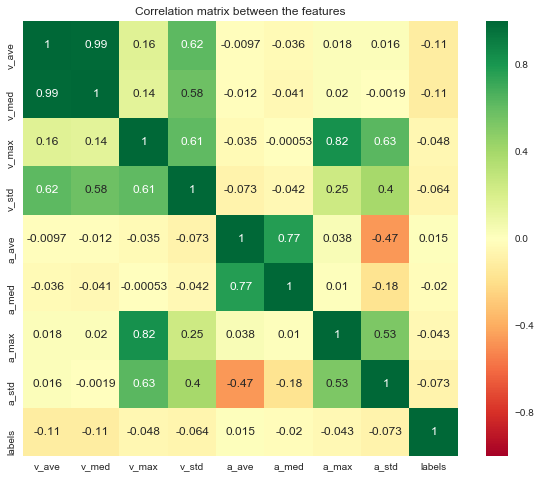

In [13]:
correlation_matrix = df_single_modality.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.show()

X = df_single_modality[X_colnames].values

[  9.38373942e-01   4.29528355e-02   1.77607572e-02   6.34078435e-04
   1.55935968e-04   7.54351114e-05   4.20783136e-05   4.93763031e-06]
[ 0.01483446  0.16045426  0.13496178  0.16830595 -0.03705418 -0.20520712
 -0.03198465  0.08936893]


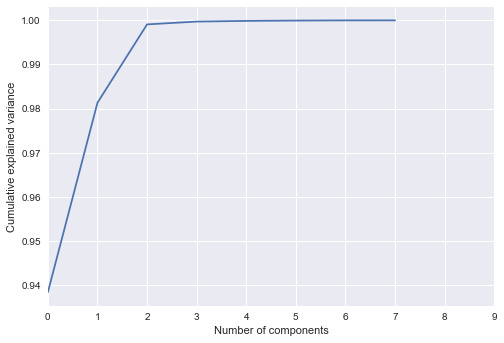

In [27]:
X_std = StandardScaler().fit_transform(X)

pca = PCA().fit(X)
var_ratio = pca.explained_variance_ratio_
components = pca.components_
print(var_ratio)
print(np.mean(pca.components_,axis=0))
plt.plot(np.cumsum(var_ratio))
plt.xlim(0,9,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()